<a href="https://colab.research.google.com/github/ayyucedemirbas/Medical_Img_Seg/blob/main/SAM_Seg_with_Prompts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segment_anything

In [3]:
SAM_CHECKPOINT_PATH = "checkpoints/sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
GDINO_CONFIG = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GDINO_CHECKPOINT_PATH = "checkpoints/groundingdino_swint_ogc.pth"
IMG_PATH = ["images/kitchen.jpeg", "images/living_room.jpg"]
TEXT_PROMPT = ["plant", "apples", "vase"]
IMG_SIZE = (256, 256)
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25
OUT_PATH = "predictions"
OUT_PROMPT_PATH = "prompt_image.jpg"
OUT_PRED_PATH = "predicted_image.jpg"

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
def show_box(box, ax, processed_dim=False):
    x0, y0 = box[0], box[1]
    if processed_dim:
        w, h = box[2], box[3]
    else:
        w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )
def show_mask(mask, ax):
    color = np.array([0, 0, 1, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
def show_all_masks(masks):
    sorted_masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones(
        (
            sorted_masks[0]["segmentation"].shape[0],
            sorted_masks[0]["segmentation"].shape[1],
            4,
        )
    )
    img[:, :, 3] = 0
    for mask in sorted_masks:
        m = mask["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
from segment_anything import SamPredictor, sam_model_registry

import cv2
import os
# function to visualize and save segmentation
def visualize_and_save_segmentation(
    prompt, model, query_index, save_multiple_masks=False
):
    input_points, input_labels, input_box = prompt
    # Create output directory if it doesn't exist
    if not os.path.exists(OUT_PATH):
        os.makedirs(OUT_PATH)
    # Define paths to save prompt and prediction images
    prompt_path = os.path.join(
        OUT_PATH, f"{query_index}-{OUT_PROMPT_PATH}"
    )
    prediction_path = os.path.join(
        OUT_PATH, f"{query_index}-{OUT_PRED_PATH}"
    )
    # Plot the input image with prompts
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    if input_points is not None:
        show_points(input_points, input_labels, plt.gca())
    if input_box is not None:
        show_box(input_box, plt.gca())
        input_box = input_box[None, :]
    # Save prompt image
    print(f"[INFO] saving the prompt image to {prompt_path}...")
    plt.savefig(prompt_path)
    # Make predictions using SAM and visualize them
    masks, scores, _ = model.predict(
        point_coords=input_points,
        point_labels=input_labels,
        box=input_box,
        multimask_output=save_multiple_masks,
    )
    # Save the predicted image
    print(f"[INFO] saving the predicted image to {prediction_path}...")
    plt.figure(figsize=(6, 6))
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.imshow(image)
        show_mask(mask, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis("on")
    plt.savefig(prediction_path)
    plt.close()

In [7]:
!mkdir checkpoints
%cd checkpoints

/content/checkpoints


In [8]:
!wget https://huggingface.co/spaces/abhishek/StableSAM/resolve/main/sam_vit_h_4b8939.pth

--2024-09-30 20:14:32--  https://huggingface.co/spaces/abhishek/StableSAM/resolve/main/sam_vit_h_4b8939.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.118, 18.164.174.17, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/47/d3/47d331d77ce5639cc128df17410f4744b11342191e8442f5cde65f20735d01f9/a7bf3b02f3ebf1267aba913ff637d9a2d5c33d3173bb679e46d9f338c26f262e?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sam_vit_h_4b8939.pth%3B+filename%3D%22sam_vit_h_4b8939.pth%22%3B&Expires=1727986472&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNzk4NjQ3Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Ny9kMy80N2QzMzFkNzdjZTU2MzljYzEyOGRmMTc0MTBmNDc0NGIxMTM0MjE5MWU4NDQyZjVjZGU2NWYyMDczNWQwMWY5L2E3YmYzYjAyZjNlYmYxMjY3YWJhOTEzZmY2MzdkOWEyZDVjMzNkMzE3M2JiNjc5ZTQ2ZDlmMzM4YzI2ZjI2MmU%7EcmVzcG

In [9]:
%cd ..

/content


[INFO] loading the image...
[INFO] loading SAM...


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


[INFO] creating prompt for query 0...
[INFO] saving the prompt image to predictions/0-prompt_image.jpg...
[INFO] saving the predicted image to predictions/0-predicted_image.jpg...
[INFO] creating prompt for query 1...
[INFO] saving the prompt image to predictions/1-prompt_image.jpg...
[INFO] saving the predicted image to predictions/1-predicted_image.jpg...
[INFO] creating prompt for query 2...
[INFO] saving the prompt image to predictions/2-prompt_image.jpg...
[INFO] saving the predicted image to predictions/2-predicted_image.jpg...
[INFO] creating prompt for query 3...
[INFO] saving the prompt image to predictions/3-prompt_image.jpg...
[INFO] saving the predicted image to predictions/3-predicted_image.jpg...
[INFO] creating prompt for query 4...
[INFO] saving the prompt image to predictions/4-prompt_image.jpg...
[INFO] saving the predicted image to predictions/4-predicted_image.jpg...


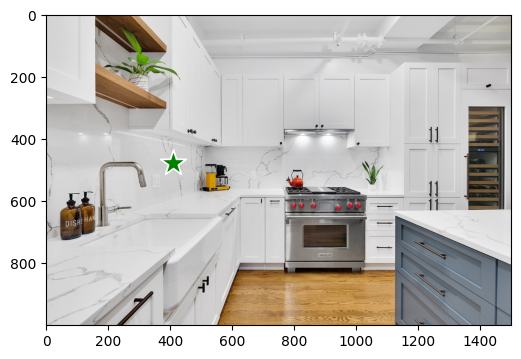

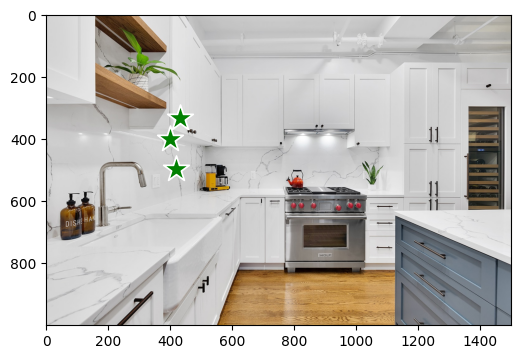

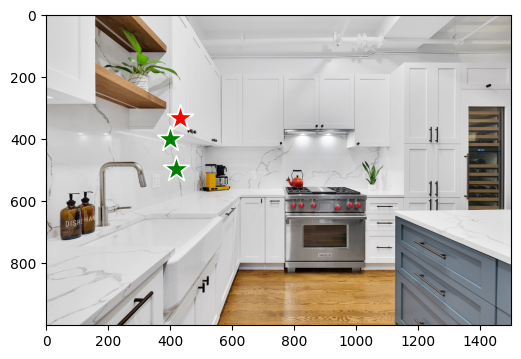

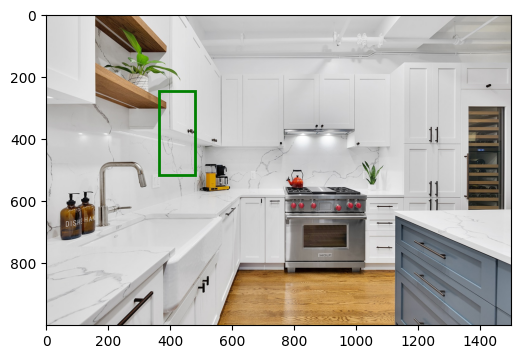

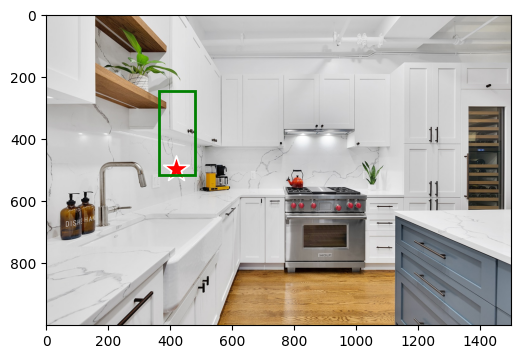

In [10]:
# Load input image and convert to RGB
print("[INFO] loading the image...")
image = cv2.imread(IMG_PATH[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Initialize and load SAM
print("[INFO] loading SAM...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
predictor = SamPredictor(sam)
predictor.set_image(image)
    # Define prompts and visualize and save segmentation
prompts = [
    (np.array([[410, 475]]), np.array([1]), None),
    (np.array([[420, 495], [400, 400], [430, 330]]), np.array([1, 1, 1]), None),
    (np.array([[420, 495], [400, 400], [430, 330]]), np.array([1, 1, 0]), None),
    (None, None, np.array([365, 243, 480, 515])),
    (np.array([[420, 495]]), np.array([0]), np.array([365, 243, 480, 515])),
]
for i, prompt in enumerate(prompts):
    print(f"[INFO] creating prompt for query {i}...")
    visualize_and_save_segmentation(prompt, predictor, i)

In [11]:
%cd checkpoints
!wget https://huggingface.co/alexgenovese/background-workflow/resolve/1cbf8c24aa8a2e8d5ca6871800442b35ff6f9d48/groundingdino_swint_ogc.pth
%cd ..

/content/checkpoints
--2024-09-30 20:17:46--  https://huggingface.co/alexgenovese/background-workflow/resolve/1cbf8c24aa8a2e8d5ca6871800442b35ff6f9d48/groundingdino_swint_ogc.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.118, 18.164.174.23, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/38/05/38057310c778bfef51ea90be46b3741400f0365ab78685026e305afe0d507359/3b3ca2563c77c69f651d7bd133e97139c186df06231157a64c507099c52bc799?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27groundingdino_swint_ogc.pth%3B+filename%3D%22groundingdino_swint_ogc.pth%22%3B&Expires=1727986666&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNzk4NjY2Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzM4LzA1LzM4MDU3MzEwYzc3OGJmZWY1MWVhOTBiZTQ2YjM3NDE0MDBmMDM2NWFiNzg2ODUwMjZlMzA1YWZlMGQ1MDczNTk

In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

In [14]:
%cd GroundingDINO

/content/GroundingDINO


In [15]:
!pip install -e .

Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 23.5 MB/s eta 0:00:00
  Running setup.py develop for groundingdino


In [16]:
import torch

In [17]:
from groundingdino.util.inference import load_image, load_model, predict

In [18]:
def get_bounding_boxes(img_path, text_prompt, box_threshold, text_threshold):
    # Load GDINO model and input image
    model = load_model(GDINO_CONFIG, GDINO_CHECKPOINT_PATH)
    _, image = load_image(img_path)
    boxes, _, _ = predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
    )
    return boxes

In [20]:
!pwd

/content/GroundingDINO


In [21]:
%cd ..

/content


[INFO] Loading image...
[INFO] Loading SAM model...


[INFO] Generating masks from SAM...


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[INFO] saving the prompt image to predictions/0-prompt_image.jpg...
[INFO] saving the predicted image to predictions/0-predicted_image.jpg...
[INFO] saving the prompt image to predictions/1-prompt_image.jpg...
[INFO] saving the predicted image to predictions/1-predicted_image.jpg...
final text_encoder_type: bert-base-uncased


final text_encoder_type: bert-base-uncased
[INFO] saving the prompt image to predictions/0-prompt_image.jpg...
[INFO] saving the predicted image to predictions/0-predicted_image.jpg...
[INFO] saving the prompt image to predictions/1-prompt_image.jpg...
[INFO] saving the predicted image to predictions/1-predicted_image.jpg...


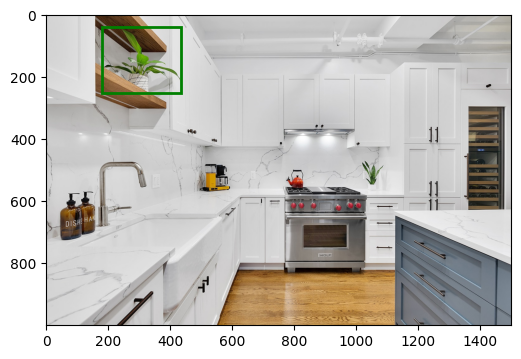

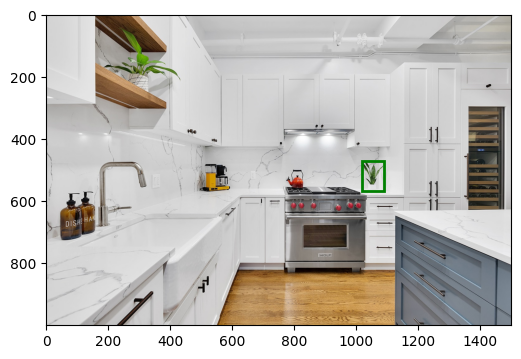

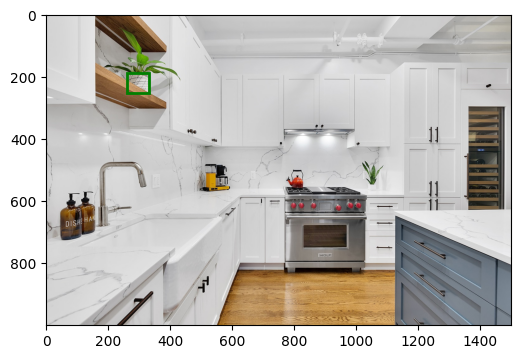

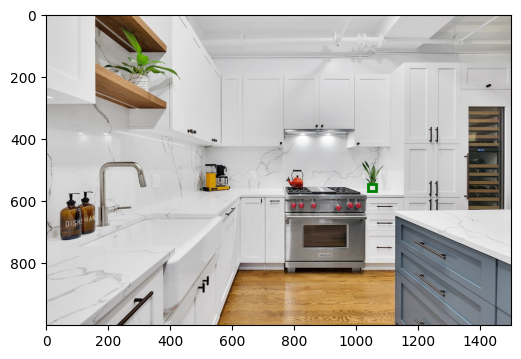

In [22]:
# Load input image and convert to RGB
print("[INFO] Loading image...")
image = cv2.imread(IMG_PATH[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
W, H = image.shape[1], image.shape[0]
# Initialize and load SAM
print("[INFO] Loading SAM model...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
predictor = SamPredictor(sam)
predictor.set_image(image)
# Process text prompts
print("[INFO] Generating masks from SAM...")
for prompt_text in TEXT_PROMPT:
    # Get bounding boxes for the given prompt
    boxes = get_bounding_boxes(
        IMG_PATH[0], prompt_text, BOX_TRESHOLD, TEXT_TRESHOLD
    )
    for index, bbox in enumerate(boxes):
        # Preprocess bounding box
        box = torch.Tensor(bbox) * torch.Tensor([W, H, W, H])
        box[:2] -= box[2:] / 2
        box[2:] += box[:2]
        x0, y0, x1, y1 = box.int().tolist()
        # Prepare SAM prompt
        input_box = np.array([x0, y0, x1, y1])
        input_point = None
        input_label = None
        segment_prompt = [input_point, input_label, input_box]
        # Segment using the prepared prompt
        visualize_and_save_segmentation(segment_prompt, predictor, index)

In [23]:
IMG_PATH = ["images/organs.jpg", "images/organs.jpg"]

In [24]:
TEXT_PROMPT = ["liver", "bowel", "heart"]

[INFO] Loading image...
[INFO] Loading SAM model...


[INFO] Generating masks from SAM...
final text_encoder_type: bert-base-uncased


[INFO] saving the prompt image to predictions/0-prompt_image.jpg...
[INFO] saving the predicted image to predictions/0-predicted_image.jpg...
[INFO] saving the prompt image to predictions/1-prompt_image.jpg...
[INFO] saving the predicted image to predictions/1-predicted_image.jpg...
[INFO] saving the prompt image to predictions/2-prompt_image.jpg...
[INFO] saving the predicted image to predictions/2-predicted_image.jpg...
final text_encoder_type: bert-base-uncased


[INFO] saving the prompt image to predictions/0-prompt_image.jpg...
[INFO] saving the predicted image to predictions/0-predicted_image.jpg...
[INFO] saving the prompt image to predictions/1-prompt_image.jpg...
[INFO] saving the predicted image to predictions/1-predicted_image.jpg...
final text_encoder_type: bert-base-uncased


[INFO] saving the prompt image to predictions/0-prompt_image.jpg...
[INFO] saving the predicted image to predictions/0-predicted_image.jpg...
[INFO] saving the prompt image to predictions/1-prompt_image.jpg...
[INFO] saving the predicted image to predictions/1-predicted_image.jpg...
[INFO] saving the prompt image to predictions/2-prompt_image.jpg...
[INFO] saving the predicted image to predictions/2-predicted_image.jpg...
[INFO] saving the prompt image to predictions/3-prompt_image.jpg...
[INFO] saving the predicted image to predictions/3-predicted_image.jpg...


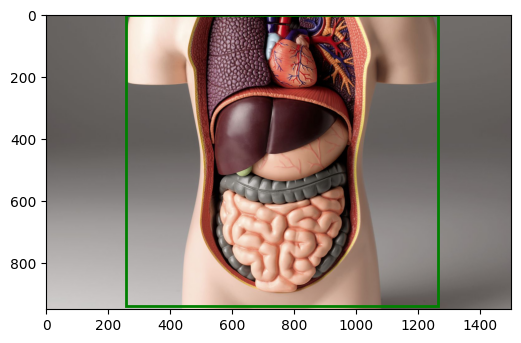

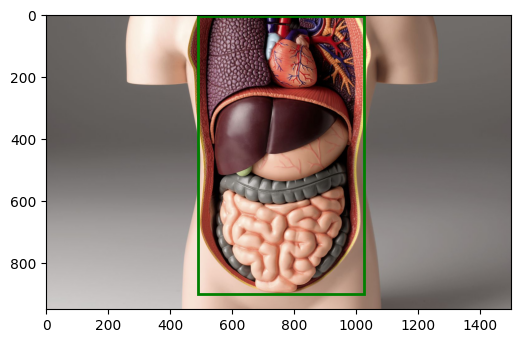

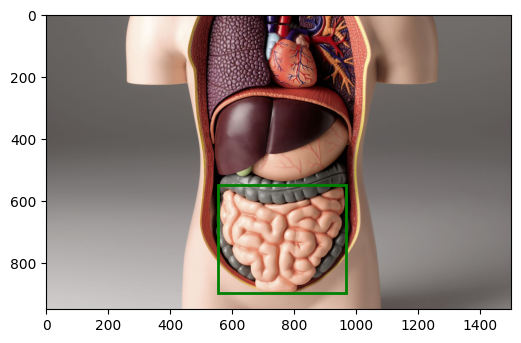

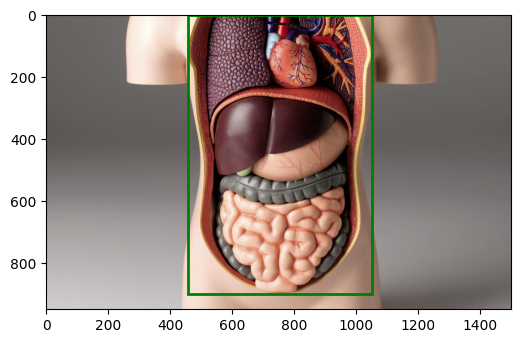

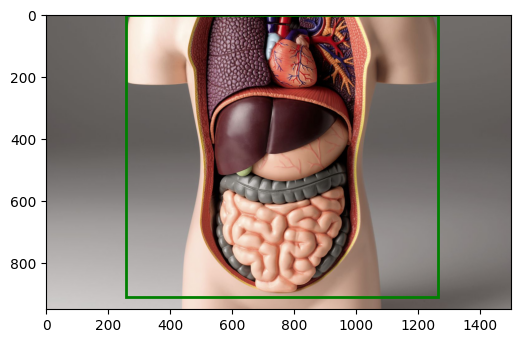

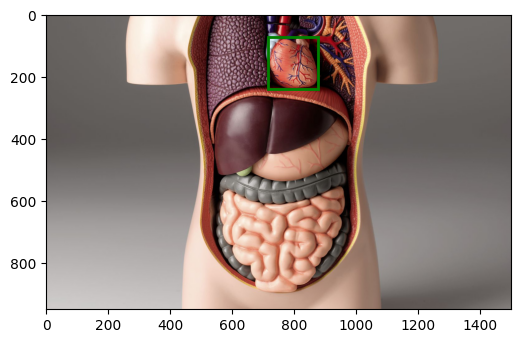

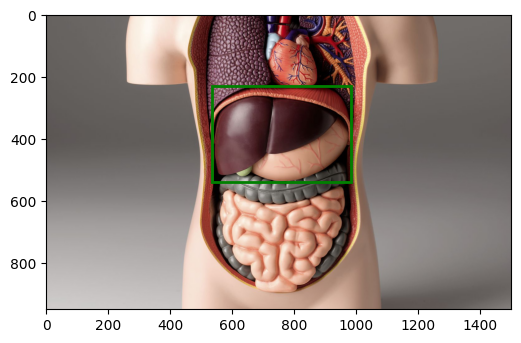

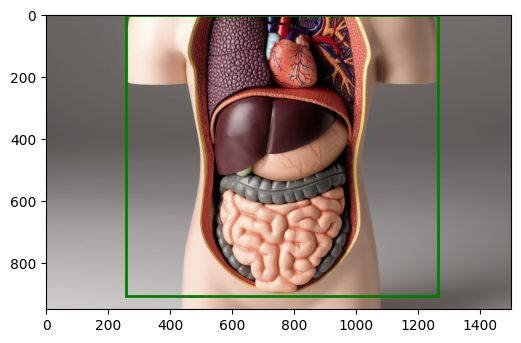

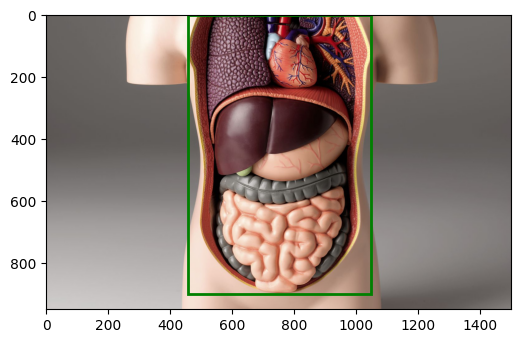

In [25]:
# Load input image and convert to RGB
print("[INFO] Loading image...")
image = cv2.imread(IMG_PATH[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
W, H = image.shape[1], image.shape[0]
# Initialize and load SAM
print("[INFO] Loading SAM model...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
predictor = SamPredictor(sam)
predictor.set_image(image)
# Process text prompts
print("[INFO] Generating masks from SAM...")
for prompt_text in TEXT_PROMPT:
    # Get bounding boxes for the given prompt
    boxes = get_bounding_boxes(
        IMG_PATH[0], prompt_text, BOX_TRESHOLD, TEXT_TRESHOLD
    )
    for index, bbox in enumerate(boxes):
        # Preprocess bounding box
        box = torch.Tensor(bbox) * torch.Tensor([W, H, W, H])
        box[:2] -= box[2:] / 2
        box[2:] += box[:2]
        x0, y0, x1, y1 = box.int().tolist()
        # Prepare SAM prompt
        input_box = np.array([x0, y0, x1, y1])
        input_point = None
        input_label = None
        segment_prompt = [input_point, input_label, input_box]
        # Segment using the prepared prompt
        visualize_and_save_segmentation(segment_prompt, predictor, index)

In [26]:
IMG_PATH = ["images/tumor.jpg", "images/organs.jpg"]

In [27]:
TEXT_PROMPT = ["tumor"]

[INFO] Loading image...
[INFO] Loading SAM model...


[INFO] Generating masks from SAM...
final text_encoder_type: bert-base-uncased


[INFO] saving the prompt image to predictions/0-prompt_image.jpg...
[INFO] saving the predicted image to predictions/0-predicted_image.jpg...
[INFO] saving the prompt image to predictions/1-prompt_image.jpg...
[INFO] saving the predicted image to predictions/1-predicted_image.jpg...


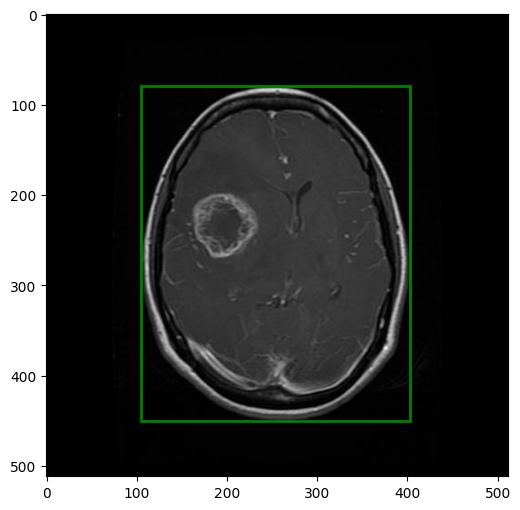

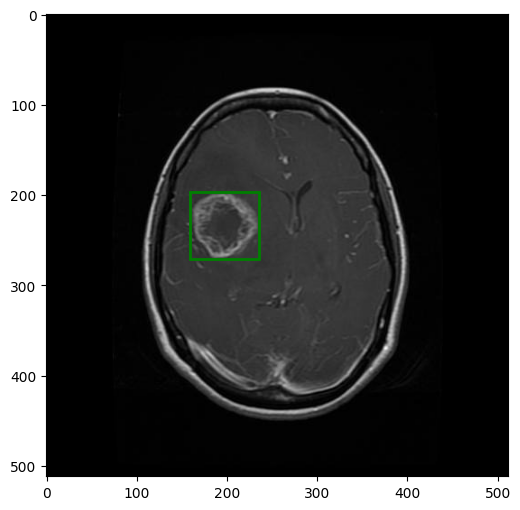

In [28]:
# Load input image and convert to RGB
print("[INFO] Loading image...")
image = cv2.imread(IMG_PATH[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
W, H = image.shape[1], image.shape[0]
# Initialize and load SAM
print("[INFO] Loading SAM model...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
predictor = SamPredictor(sam)
predictor.set_image(image)
# Process text prompts
print("[INFO] Generating masks from SAM...")
for prompt_text in TEXT_PROMPT:
    # Get bounding boxes for the given prompt
    boxes = get_bounding_boxes(
        IMG_PATH[0], prompt_text, BOX_TRESHOLD, TEXT_TRESHOLD
    )
    for index, bbox in enumerate(boxes):
        # Preprocess bounding box
        box = torch.Tensor(bbox) * torch.Tensor([W, H, W, H])
        box[:2] -= box[2:] / 2
        box[2:] += box[:2]
        x0, y0, x1, y1 = box.int().tolist()
        # Prepare SAM prompt
        input_box = np.array([x0, y0, x1, y1])
        input_point = None
        input_label = None
        segment_prompt = [input_point, input_label, input_box]
        # Segment using the prepared prompt
        visualize_and_save_segmentation(segment_prompt, predictor, index)